# Complex Systems Project #
### Antibiotic Resistance in Bacteria
##### by Maryna Borovyk and Illia Pastushok

In [119]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [120]:
params = {
    'gS': 1.0,          # Growth rate of sensitive bacteria (1/h)
    'gR': 0.65,         # Growth rate of resistant bacteria (1/h)
    'K': 1e9,           # Carrying capacity (cells)
    'lambda': 0.7,      # Conjugation rate (1/h)
    'p': 0.5,           # Probability of plasmid loss
    'd': 0.5,           # Natural death rate (1/h)
    'ES_max': 1.5,      # Max kill rate for sensitive bacteria (1/h)
    'ER_max': 1.1,      # Max kill rate for resistant bacteria (1/h)
    'AS_50': 0.25,      # Half-max effect concentration (sensitive) (μg/ml)
    'AR_50': 5.0,       # Half-max effect concentration (resistant) (μg/ml)
    'alpha': 0.15       # Antibiotic elimination rate (1/h)
}

K is max number of bacterias
there might nbe a condition hidden in equation
max population can be as y lim K
try simpler equation without horizontal


In [121]:
# Define the sigmoid function for the killing rate
def mu_i(Emax, A, A50):
    return Emax * A / (A50 + A)

# Define the antibiotic concentration function with multiple doses
def A_t(t, A0, alpha, tau):
    i = int(t // tau)
    if t == i * tau:
        return sum(A0 * np.exp(-j * alpha * tau) for j in range(i + 1))
    else:
        return sum(A0 * np.exp(-j * alpha * tau) for j in range(i)) * np.exp(-alpha * (t - (i - 1) * tau))


# Differential equations for the model
def model(y, t, params):
    S, R = y  # Sensitive and Resistant bacteria
    A = A_t(t, 0, params['alpha'], 6)  # Antibiotic concentration
    mu_S = mu_i(params['ES_max'], A, params['AS_50'])
    mu_R = mu_i(params['ER_max'], A, params['AR_50'])

    # dS/dt and dR/dt
    dSdt = params['gS'] * (1 - (S + R) / params['K']) * S \
           - (params['lambda'] * S * R / (S + R))  \
           + params['p'] * params['gR'] * R \
           - (mu_S + params['d']) * S

    dRdt = params['gR'] * (1 - (S + R) / params['K']) * R \
           + (params['lambda'] * S * R / (S + R)) \
           - params['p'] * params['gR'] * R \
          - (mu_R + params['d']) * R

    return [dSdt, dRdt]


In [122]:
# Initial conditions
S0 = 1e3   # Initial sensitive bacteria
R0 = 1e3   # Initial resistant bacteria
initial_conditions = [S0, R0]

# Time span for the simulation (e.g., 0 to 120 hours)
time = np.linspace(0, 120, 500)

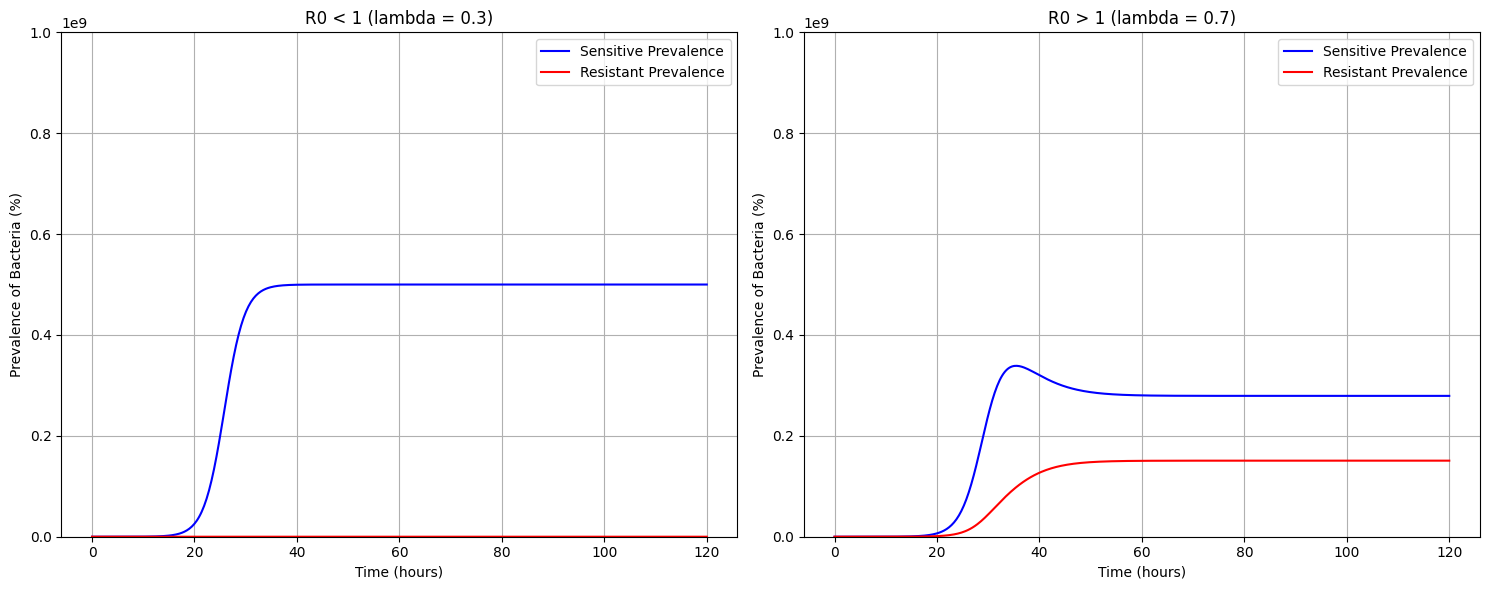

In [123]:
# --- Recreate Figure 2 ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

K = 1e9  # Define your K parameter

# 2a: R0 < 1 (lambda = 0.3)
params['lambda'] = 0.3
solution = odeint(model, initial_conditions, time, args=(params,))
S, R = solution[:, 0], solution[:, 1]
axes[0].plot(time, S , label="Sensitive Prevalence", color="blue")
axes[0].plot(time, R , label="Resistant Prevalence", color="red")
axes[0].set_ylim(0, K)  # Set y-axis limit
axes[0].set_title("R0 < 1 (lambda = 0.3)")
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Prevalence of Bacteria (%)")
axes[0].legend()
axes[0].grid()

# 2b: R0 > 1 (lambda = 0.7)
params['lambda'] = 0.7
solution = odeint(model, initial_conditions, time, args=(params,))
S, R = solution[:, 0], solution[:, 1]
axes[1].plot(time, S , label="Sensitive Prevalence", color="blue")
axes[1].plot(time, R , label="Resistant Prevalence", color="red")
axes[1].set_ylim(0, K)  # Set y-axis limit
axes[1].set_title("R0 > 1 (lambda = 0.7)")
axes[1].set_xlabel("Time (hours)")
axes[1].set_ylabel("Prevalence of Bacteria (%)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [127]:
# Differential equations for the rescaled model
def rescaled_model(y, t, params):
    s, r = y  # Rescaled sensitive and resistant bacteria
    A = A_t(t, 0, params['alpha'], 6)  # Antibiotic concentration
    mu_S = mu_i(params['ES_max'], A, params['AS_50'])
    mu_R = mu_i(params['ER_max'], A, params['AR_50'])

    # ds/dt and dr/dt
    dsdt = (1 - (s + r)) * params['gS'] * s \
           - (params['lambda'] * s * r / (s + r)) \
           + (params['gR'] * params['p'] / 2) * r \
           - (mu_S + params['d']) * s

    drdt = (1 - (s + r)) * params['gR'] * r \
           + (params['lambda'] * s * r / (s + r)) \
           - (params['gR'] * params['p'] / 2) * r \
           - (mu_R + params['d']) * r

    return [dsdt, drdt]

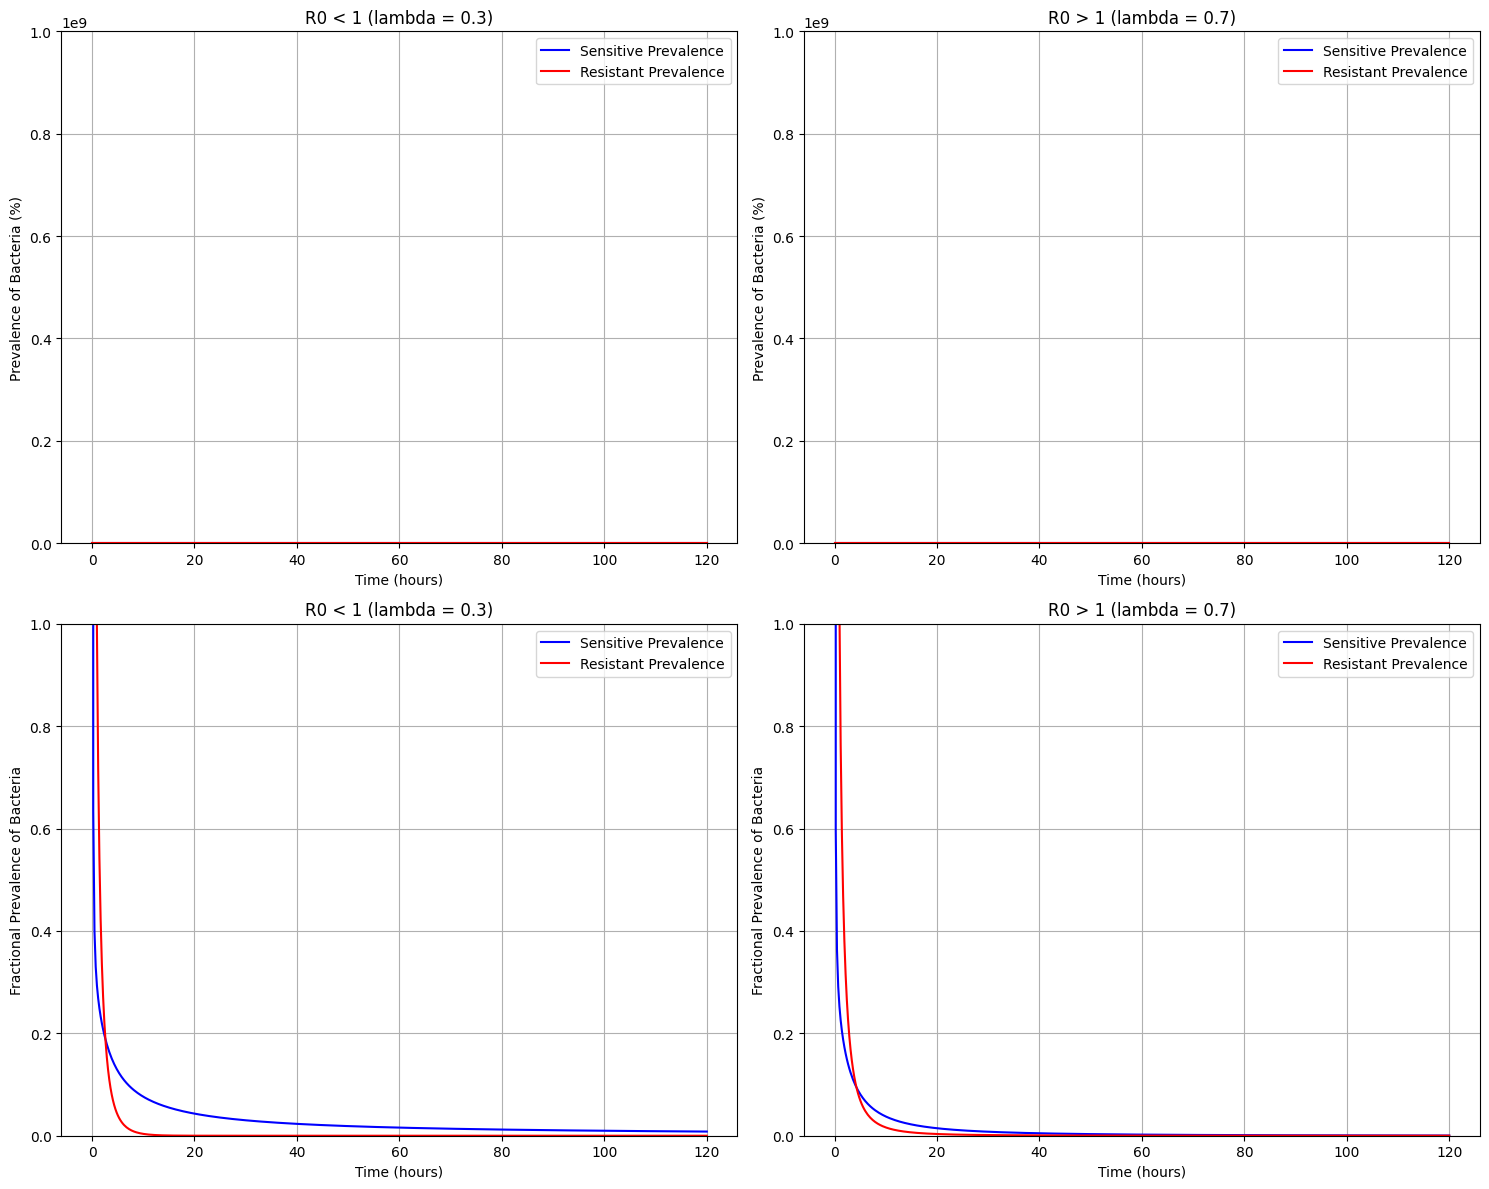

In [129]:
# --- Recreate Figure 2 ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

K = 1e9  # Define your K parameter

# 2a: R0 < 1 (lambda = 0.3)
params['lambda'] = 0.3
solution = odeint(model, initial_conditions, time, args=(params,))
S, R = solution[:, 0], solution[:, 1]
axes[0, 0].plot(time, S , label="Sensitive Prevalence", color="blue")
axes[0, 0].plot(time, R , label="Resistant Prevalence", color="red")
axes[0, 0].set_ylim(0, K)  # Set y-axis limit
axes[0, 0].set_title("R0 < 1 (lambda = 0.3)")
axes[0, 0].set_xlabel("Time (hours)")
axes[0, 0].set_ylabel("Prevalence of Bacteria (%)")
axes[0, 0].legend()
axes[0, 0].grid()

# 2b: R0 > 1 (lambda = 0.7)
params['lambda'] = 0.7
solution = odeint(model, initial_conditions, time, args=(params,))
S, R = solution[:, 0], solution[:, 1]
axes[0, 1].plot(time, S , label="Sensitive Prevalence", color="blue")
axes[0, 1].plot(time, R , label="Resistant Prevalence", color="red")
axes[0, 1].set_ylim(0, K)  # Set y-axis limit
axes[0, 1].set_title("R0 > 1 (lambda = 0.7)")
axes[0, 1].set_xlabel("Time (hours)")
axes[0, 1].set_ylabel("Prevalence of Bacteria (%)")
axes[0, 1].legend()
axes[0, 1].grid()


# 2a: R0 < 1 (lambda = 0.3)
params['lambda'] = 0.3
solution1 = odeint(rescaled_model, initial_conditions, time, args=(params,))
s, r = solution1[:, 0], solution1[:, 1]
axes[1, 0].plot(time, s, label="Sensitive Prevalence", color="blue")
axes[1, 0].plot(time, r, label="Resistant Prevalence", color="red")
axes[1, 0].set_ylim(0, 1)  # Set y-axis limit to 1 for fractional values
axes[1, 0].set_title("R0 < 1 (lambda = 0.3)")
axes[1, 0].set_xlabel("Time (hours)")
axes[1, 0].set_ylabel("Fractional Prevalence of Bacteria")
axes[1, 0].legend()
axes[1, 0].grid()

# 2b: R0 > 1 (lambda = 0.7)
params['lambda'] = 0.7
solution1 = odeint(rescaled_model, initial_conditions, time, args=(params,))
s, r = solution1[:, 0], solution1[:, 1]
axes[1, 1].plot(time, s, label="Sensitive Prevalence", color="blue")
axes[1, 1].plot(time, r, label="Resistant Prevalence", color="red")
axes[1, 1].set_ylim(0, 1)  # Set y-axis limit to 1 for fractional values
axes[1, 1].set_title("R0 > 1 (lambda = 0.7)")
axes[1, 1].set_xlabel("Time (hours)")
axes[1, 1].set_ylabel("Fractional Prevalence of Bacteria")
axes[1, 1].legend()
axes[1, 1].grid()

plt.tight_layout()
plt.show()

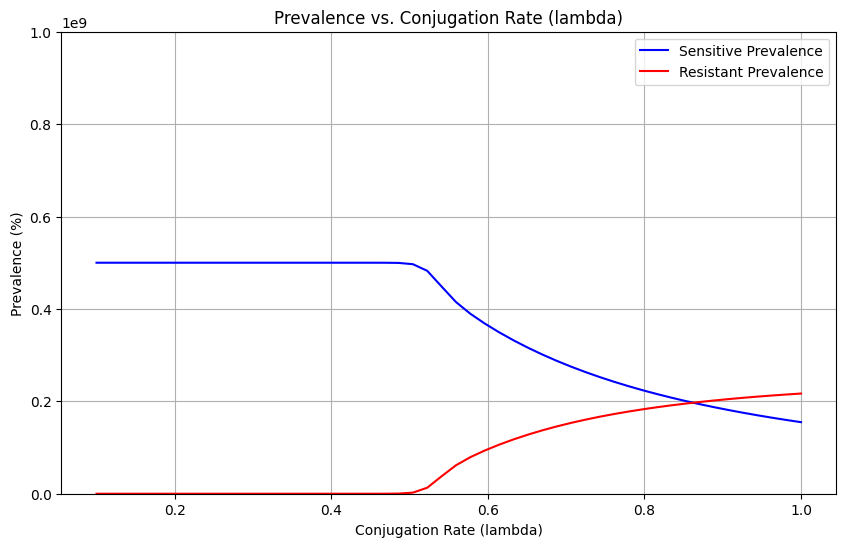

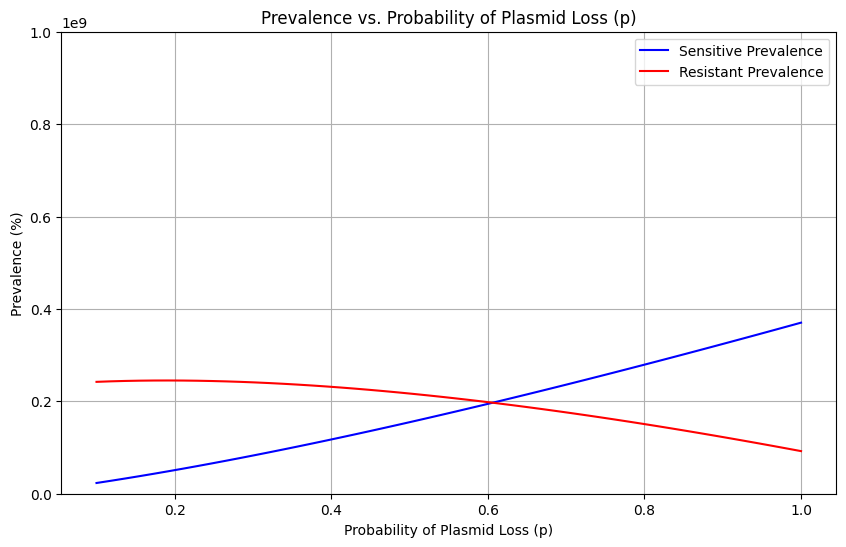

KeyboardInterrupt: 

In [126]:
# --- Recreate Figure 3 ---

# 3a: Prevalence vs. conjugation rate (lambda)
conjugation_rates = np.linspace(0.1, 1.0, 50)
S_prevalence = []
R_prevalence = []
for lam in conjugation_rates:
    params['lambda'] = lam
    solution = odeint(model, initial_conditions, time, args=(params,))
    S, R = solution[-1, 0], solution[-1, 1]
    S_prevalence.append(S)
    R_prevalence.append(R)

plt.figure(figsize=(10, 6))
plt.plot(conjugation_rates, S_prevalence, label="Sensitive Prevalence", color="blue")
plt.plot(conjugation_rates, R_prevalence, label="Resistant Prevalence", color="red")
plt.ylim(0, K)  # Set y-axis limit
plt.title("Prevalence vs. Conjugation Rate (lambda)")
plt.xlabel("Conjugation Rate (lambda)")
plt.ylabel("Prevalence (%)")
plt.legend()
plt.grid()
plt.show()

# 3b: Prevalence vs. probability of plasmid loss (p)
plasmid_loss_rates = np.linspace(0.1, 1.0, 50)
S_prevalence = []
R_prevalence = []
for p in plasmid_loss_rates:
    params['p'] = p
    solution = odeint(model, initial_conditions, time, args=(params,))
    S, R = solution[-1, 0], solution[-1, 1]
    S_prevalence.append(S )
    R_prevalence.append(R )

plt.figure(figsize=(10, 6))
plt.plot(plasmid_loss_rates, S_prevalence, label="Sensitive Prevalence", color="blue")
plt.plot(plasmid_loss_rates, R_prevalence, label="Resistant Prevalence", color="red")
plt.title("Prevalence vs. Probability of Plasmid Loss (p)")
plt.ylim(0, K)  # Set y-axis limit
plt.xlabel("Probability of Plasmid Loss (p)")
plt.ylabel("Prevalence (%)")
plt.legend()
plt.grid()
plt.show()

# 3c: Prevalence vs. mortality rate (d)
mortality_rates = np.linspace(0.1, 1.0, 50)
S_prevalence = []
R_prevalence = []
for d in mortality_rates:
    params['d'] = d
    solution = odeint(model, initial_conditions, time, args=(params,))
    S, R = solution[-1, 0], solution[-1, 1]
    S_prevalence.append(S )
    R_prevalence.append(R )

plt.figure(figsize=(10, 6))
plt.plot(mortality_rates, S_prevalence, label="Sensitive Prevalence", color="blue")
plt.plot(mortality_rates, R_prevalence, label="Resistant Prevalence", color="red")
plt.title("Prevalence vs. Mortality Rate (d)")
plt.ylim(0, K)  # Set y-axis limit
plt.xlabel("Mortality Rate (d)")
plt.ylabel("Prevalence (%)")
plt.legend()
plt.grid()
plt.show()

# 3d and 3e: Heatmaps for (lambda, p)
lam_range = np.linspace(0.1, 1.0, 50)
p_range = np.linspace(0.1, 1.0, 50)
lam_grid, p_grid = np.meshgrid(lam_range, p_range)
S_heatmap = np.zeros_like(lam_grid)
R_heatmap = np.zeros_like(lam_grid)

for i, lam in enumerate(lam_range):
    for j, p in enumerate(p_range):
        params['lambda'] = lam
        params['p'] = p
        solution = odeint(model, initial_conditions, time, args=(params,))
        S, R = solution[-1, 0], solution[-1, 1]
        S_heatmap[j, i] = S
        R_heatmap[j, i] = R

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

im1 = axes[0].imshow(S_heatmap, extent=[0.1, 1.0, 0.1, 1.0], origin="lower", aspect="auto", cmap="Blues")
axes[0].set_title("Sensitive Prevalence")
axes[0].set_xlabel("Conjugation Rate (lambda)")
axes[0].set_ylabel("Probability of Plasmid Loss (p)")
axes[0].set_ylim(0, K)
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(R_heatmap, extent=[0.1, 1.0, 0.1, 1.0], origin="lower", aspect="auto", cmap="Reds")
axes[1].set_title("Resistant Prevalence")
axes[1].set_xlabel("Conjugation Rate (lambda)")
axes[1].set_ylabel("Probability of Plasmid Loss (p)")
axes[1].set_ylim(0, K)
fig.colorbar(im2, ax=axes[1])

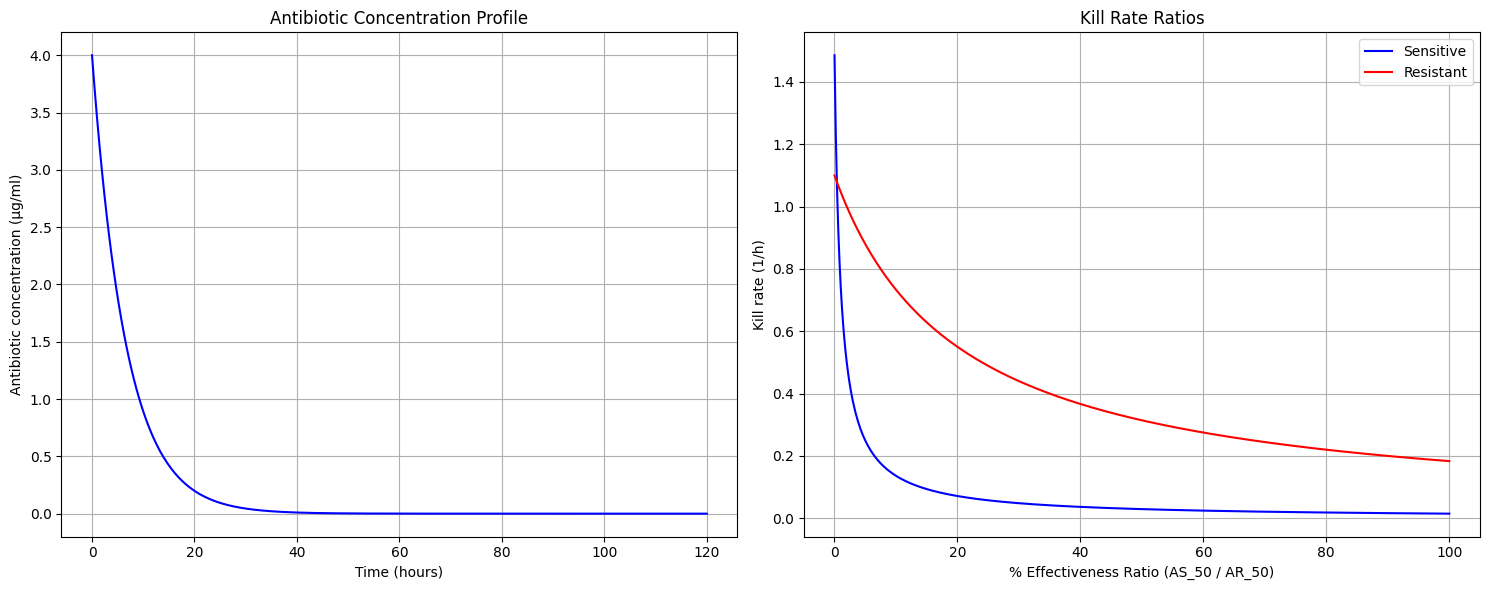

In [ ]:
# --- Recreate Figure 4 ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 4a: Antibiotic concentration profile
A0 = 4  # Initial dose (μg/ml)
doses = [0]  # Single dose administered at t=0
antibiotic_levels = [antibiotic_concentration(t, doses, A0, params['alpha']) for t in time]

axes[0].plot(time, antibiotic_levels, color="blue")
axes[0].set_title("Antibiotic Concentration Profile")
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Antibiotic concentration (μg/ml)")
axes[0].grid()

# 4b: Ratio of kill rates vs. varying antibiotic concentration ratios
sensitive_kill_rates = []
resistant_kill_rates = []
concentration_ratios = np.linspace(0.01, 100, 500)  # AR_50 / AS_50 ratio

for ratio in concentration_ratios:
    AS = params['AS_50'] * ratio  # Adjust antibiotic efficacy for sensitive bacteria
    kill_S = params['ES_max'] / (1 + AS / params['AS_50'])
    kill_R = params['ER_max'] / (1 + AS / params['AR_50'])
    sensitive_kill_rates.append(kill_S)
    resistant_kill_rates.append(kill_R)

axes[1].plot(concentration_ratios, sensitive_kill_rates, label="Sensitive", color="blue")
axes[1].plot(concentration_ratios, resistant_kill_rates, label="Resistant", color="red")
axes[1].set_title("Kill Rate Ratios")
axes[1].set_xlabel("% Effectiveness Ratio (AS_50 / AR_50)")
axes[1].set_ylabel("Kill rate (1/h)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# Reset params to original values
params['lambda'] = 0.7
params['p'] = 0.5
params['d'] = 0.5
